In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp")

S = 128

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * B[k, j])

    return [C]

mmul = tf.program(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 2
  Intermediate buffers: 5
  Lines of generated code: 114
  IR size: 67



In [2]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Bnp @ Anp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[29.557901 27.938738 29.042233 ... 30.470295 27.340082 24.32231 ]
 [29.548323 27.24829  29.777672 ... 30.910482 30.82712  25.498152]
 [31.248177 31.94926  30.471178 ... 33.961025 29.860981 27.242235]
 ...
 [33.426075 33.759502 33.136288 ... 35.423065 33.48935  27.185137]
 [32.51863  31.741915 30.325848 ... 33.85554  31.308252 27.414125]
 [32.30878  33.35017  30.861977 ... 32.27634  31.468746 27.48239 ]]
[[29.557901 27.938736 29.04224  ... 30.4703   27.340075 24.322315]
 [29.548332 27.248302 29.777668 ... 30.910486 30.827118 25.498161]
 [31.248173 31.94926  30.471176 ... 33.96103  29.860981 27.242233]
 ...
 [33.426075 33.759502 33.136288 ... 35.423054 33.48935  27.185139]
 [32.51863  31.741907 30.325848 ... 33.855545 31.308247 27.414122]
 [32.308784 33.35017  30.861977 ... 32.276337 31.468748 27.482391]]
[[ 0.0000000e+00  1.9073486e-06 -7.6293945e-06 ... -5.7220459e-06
   7.6293945e-06 -5.7220459e-06]
 [-9.5367432e-06 -1.3351440e-05  3.8146973e-06 ... -3.8146973e-06
   1.9073486e-06 -9

In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

# Performance test
t0 = time.time()
for i in range(50):
    C, = mmul(A, B)
t1 = time.time()

tf_time = t1 - t0
print("TensorFrost: ", t1 - t0)

t0 = time.time()
for i in range(50):
    Cnp2 = Bnp @ Anp
t1 = time.time()

np_time = t1 - t0
print("Numpy: ", t1 - t0)

print("TF/NP: ", tf_time / np_time)

TensorFrost:  0.1379988193511963
Numpy:  0.0029997825622558594
TF/NP:  46.00294070894929


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    t0 = time.time()
    for i in range(200):
        C, = mmul(A, B)
    t1 = time.time()

    tf_time = t1 - t0

    t0 = time.time()
    for i in range(200):
        Cnp2 = Bnp @ Anp
    t1 = time.time()

    np_time = t1 - t0

    return tf_time, np_time

sizes = [2**i for i in range(5, 10)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

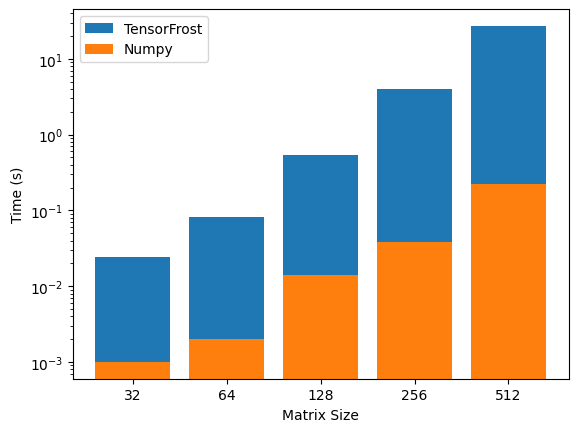

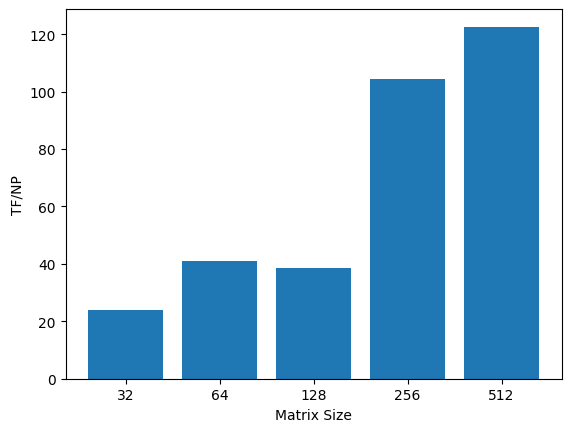

[0.023999929428100586, 0.0820014476776123, 0.5399987697601318, 3.9700002670288086, 27.22200036048889]
[0.0010001659393310547, 0.0019979476928710938, 0.014000177383422852, 0.03800034523010254, 0.2220001220703125]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)